# Keras - 1D Linear Fitting

We are now going to explore how to implement a very simple 1D linear regression with Keras. 

Let's start defining the parameters of an ideal linear function which we are going to predict through a linear fitting.

In [5]:
# target parameters of f(x) = m*x + b
m = 3 # slope
b = 0 # intersect

Now let's generate a set of input data which will slightly deviate from our ideal behaviour using a random noise:

In [6]:
# here we are going to use Keras and numpy
import numpy as np

# generate training inputs
x = np.arange(-1, 1, 0.1)
y_target = m * x + b # ideal (target) linear function

noise_amp = 1.0 # noise amplitude
y_train = m * x + b + noise_amp * (np.random.rand(len(x))-0.5) # actual measures from which we want to guess regression parameters

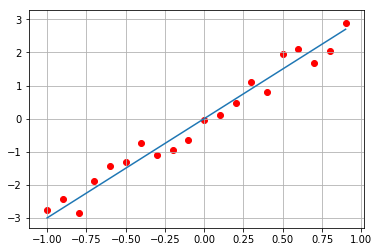

In [7]:
# plot training and target dataset
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(x, y_target)
plt.scatter(x, y_train, color='r')
plt.grid(True); plt.show()

If you remember how a single node of a neural network works, you can easily spot that just a single neuron can make the job. So let's start using a simple Sequential model with just one layer on one neuron only!

In [12]:
# compose the NN model
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

model = tf.keras.Sequential()
model.add(Dense(1, input_shape=(1,)))

# compile the model choosing optimizer, loss and metrics objects
model.compile(optimizer='sgd', loss='mse', metrics=['mse']) # metrics is optional here

aggiungere grafico per mostrare mappa di 2 parametri con peso neurone e bias
qui usiamo mse, cioè proprio i minimi quadrati che utilizzeremmo per la stima dei parametri per un fit lineare

In [13]:
# get a summary of our composed model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


We are now going to train our model, that is we feed the neuron with the set of training pair x, y_train from which the optimizer will find the best weights to minimize the Mean Square Error loss function (out linear regression function).

In [14]:
# we have to choice the batch_size and epochs
batch_size=100 # defaults to 32
epochs=1000

model.fit(x, y_train,
          batch_size=batch_size,
          epochs=epochs,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x, y_target), # used to evaluate the loss and any model metrics at each epoch
          verbose=0, # 1 get a line per epoch reporting loss and metric data
          )

score = model.evaluate(x, y_target, verbose=0)
print("Accuracy: %.2f%%" % (score[1]*100))

Accuracy: 0.48%


In [15]:
# return weights
model.get_weights()

[array([[2.8795085]], dtype=float32), array([-0.00351556], dtype=float32)]

# Keras model.fit available callbacks

The <font color'red'>.fit</font> method can also get <a href=https://keras.io/callbacks/>callback</a> functions which can be used to customize the fitting procedure with special actions.

Keras provides some predefined callbacks to feed in, among them for example:
- TerminateOnNaN(): that terminates training when a NaN loss is encountered
- ProgbarLogger(): that prints metrics to stdout
- ModelCheckpoint(filepath): that save the model after every epoch
- EarlyStopping: which stop training when a monitored quantity has stopped improving
- LambdaCallback:  for creating simple, custom callbacks on-the-fly

You can select one or more callback and pass them as a list to the callback argument of the fit method.

You can also create a callback object from scratch, customizing its behaviour overloading the base methods of the Callback Keras class:
- on_epoch_begin and on_epoch_end
- on_batch_begin and on_batch_end
- on_train_begin and on_train_end

A callback has access to its associated model through the class property self.model, so that you can monitor and access many of the quantities which are in the optimization process.

Now we are going to construct a callback object to represent how estimated parameters are converging during the training procedure

In [7]:
from IPython.display import clear_output

class PlotCurrentEstimate(tf.keras.callbacks.Callback):
    def __init__(self, x_valid, y_valid):
        """Keras Callback which plot current model estimate against reference target"""
        
        # convert numpy arrays into lists for plotting purposes
        self.x_valid = list(x_valid[:])
        self.y_valid = list(y_valid[:])
        self.iter=0

    def on_epoch_end(self, epoch, logs={}):
        
        temp = self.model.predict(self.x_valid, batch_size=None, verbose=False, steps=None)
        self.y_curr = list(temp[:]) # convert numpy array into list
        
        self.iter+=1
        if self.iter%10 == 0:
            clear_output(wait=True)            
            self.eplot = plt.subplot(1,1,1)
            self.eplot.clear()     
            self.eplot.scatter(self.x_valid, self.y_curr, color="blue", s=4, marker="o", label="estimate")
            self.eplot.scatter(self.x_valid, self.y_valid, color="red", s=4, marker="x", label="valid")
            self.eplot.legend()

            plt.show()

We will use also an EarlyStopping callback on the val_loss quantity. This will stop the training process as soon as the val_loss quantity does not improve anymore after an amount of epochs, preventing a long time of wated computation to take over without useful results.

<b>keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)</B>

Stop training when a monitored quantity has stopped improving.

Arguments:

- <b>monitor</b>: quantity to be monitored. 
- <b>min_delta:</b> minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement. 
- <b>patience:</b> number of epochs with no improvement after which training will be stopped. 
- <B>verbose:</B> verbosity mode. 
- <B>mode:</B> one of {auto, min, max}. In min mode, training will stop when the quantity monitored has stopped decreasing; in max mode it will stop when the quantity monitored has stopped increasing; in auto mode, the direction is automatically inferred from the name of the monitored quantity. 
- <B>baseline:</B> Baseline value for the monitored quantity to reach. Training will stop if the model doesn't show improvement over the baseline. 
- <B>restore_best_weights:</B> whether to restore model weights from the epoch with the best value of the monitored quantity. If False, the model weights obtained at the last step of training are used.

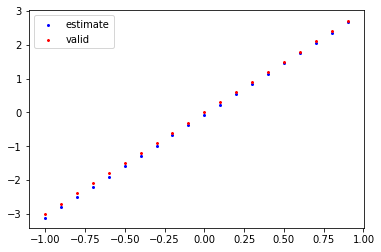

20/20 [==============================] - 0s 14ms/step - loss: 0.1069 - val_loss: 0.0065
Epoch 101/1000
20/20 [==============================] - 0s 376us/step - loss: 0.1069 - val_loss: 0.0065


[array([[3.046707]], dtype=float32), array([-0.07363325], dtype=float32)]

In [8]:
plot_estimate = PlotCurrentEstimate(x, y_target)

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                  min_delta=0, patience=100, mode='auto')

model.fit(x, y_train, batch_size=100, epochs=1000,
          validation_data=(x, y_target),
          callbacks=[ plot_estimate, earlystop]
          )

model.get_weights()

# Exercises
  
1. Try to use different <a href="https://keras.io/optimizers/">Keras optimizers</a>

1. Try to extend the model to fit a polynomial of order <code>N</code>.
  - How many layers do you need? 
  - Can you make good prediction using a non-linear activation function?
  - Can you identify the meaning of weights?


1. Try to extend the model with at least two layers and fit a 2D Gaussian distribution or a simple trigonometric 2D function such as <code>f(x,y) = sin(x+y)</code>